# Import libraries

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import os,cv2
import matplotlib.pyplot as plt

from tensorflow.keras.utils import normalize
from tensorflow.keras import backend as K

In [ ]:
# import tensorflow.keras as keras
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, add, Activation
# from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda

# Load image volume and image preprocessing

In [4]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume.npy', 'rb') as f:
    train_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume.npy', 'rb') as f:
    train_masks = np.load(f)

In [5]:
image_dataset = np.expand_dims(train_images / np.max(train_images), 3) # only the images need normalization
mask_dataset = np.expand_dims(train_masks, 3)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, 
                                                    test_size = 0.20, random_state = 0)

# Do the correspondence check between image and its mask

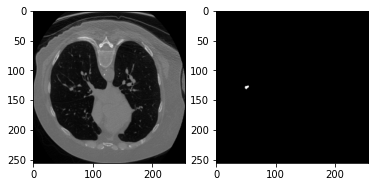

In [ ]:
import random 
image_number = random.randint(0,len(X_train))
plt.figure()
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256,256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256,256)), cmap='gray')
plt.show()

# 2 Models

## Multi Res Unet Model Definition

In [6]:
def MultiResBlock(U, input, alpha = 1.67):
  '''
  U: the number of filters in the corresponding layer of U-Net
  α: a scalar coefficient.

  We compare our proposed model with an U-Net, having #filters = [32, 64, 128, 256, 512] 
  along the levels, which are also the values of U in our model. 
  We set α = 1.67 as it keeps the number of parameters in our model slightly below that of U-Net.
  '''

  W = alpha * U
  # shortcut = input # used for the add operation
  shortcut = Conv2D(int(W/6) + int(W/3) + int(W/2), (1,1), padding='same', kernel_initializer='he_normal')(input)
  # shortcut = BatchNormalization()(shortcut)

  conv3x3 = Conv2D(int(W/6), (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(input)
  conv5x5 = Conv2D(int(W/3), (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3x3)
  conv7x7 = Conv2D(int(W/2), (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5x5)

  concat = concatenate([conv3x3, conv5x5, conv7x7])

  output = add([shortcut, concat])
  output = Activation('relu')(output)

  return output

In [7]:
def ResPath(input, length, filter):
  '''
  In particular, we use 4, 3, 2, 1 convolutional blocks respectively along the four Res paths.
  Also, in order to account for the number of feature maps in encoder–decoder, we
  use 32, 64, 128, 256 filters in the blocks of the four Res paths respectively
  '''
  # The first block takes input as input, 
  # while the later ones take the intermediate result as input
  shortcut = Conv2D(filter, (1,1), padding='same', kernel_initializer='he_normal')(input)

  conv3x3 = Conv2D(filter, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(input)
  output = add([shortcut, conv3x3])
  output = Activation('relu')(output)

  for i in range(length-1):
    shortcut = Conv2D(filter, (1,1), padding='same', kernel_initializer='he_normal')(output)

    conv3x3 = Conv2D(filter, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(output)
    output = add([shortcut, conv3x3])
    output = Activation('relu')(output)

  return output

In [8]:
def MyMultiResUnet(H, W, C):
  inputs = Input((H,W,C))

  # Contractive path
  m1 = MultiResBlock(32, inputs)
  p1 = MaxPooling2D((2,2))(m1)
  r1 = ResPath(m1, 4, 32)

  m2 = MultiResBlock(64, p1)
  p2 = MaxPooling2D((2,2))(m2)
  r2 = ResPath(m2, 3, 64)

  m3 = MultiResBlock(128, p2)
  p3 = MaxPooling2D((2,2))(m3)
  r3 = ResPath(m3, 2, 128)

  m4 = MultiResBlock(256, p3)
  p4 = MaxPooling2D((2,2))(m4)
  r4 = ResPath(m4, 1, 256)

  # Bottle neck
  m5 = MultiResBlock(512, p4) #p2

  # Expansive path
  u6 = Conv2DTranspose(256, (2,2), strides = (2,2), padding = 'same')(m5)
  u6 = concatenate([u6,r4])
  m6 = MultiResBlock(256, u6)

  u7 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(m6)
  u7 = concatenate([u7, r3])
  m7 = MultiResBlock(128, u7)

  u8 = Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(m7) #m5
  u8 = concatenate([u8, r2])
  m8 = MultiResBlock(64, u8)

  u9 = Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(m8)
  u9 = concatenate([u9, r1])
  m9 = MultiResBlock(32, u9)

  outputs = Conv2D(1, (1,1), activation = 'sigmoid')(m9)

  model = Model(inputs = [inputs], outputs=[outputs])
#   model.summary()

  return model

## The original paper one

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])
    model.summary()

    return model


# Define loss and metrics

In [9]:
def dice_coef(y_true, y_pred):
    smooth = 0.1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

In [10]:
def jaccard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  jaccard_coef = (intersection + 1.0)/ (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)  # 1 is probably used to avoid nan for 0/0 
  return jaccard_coef


# Load model and train

In [11]:
# model takes in 3 parameters H, W, C
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [12]:
multiresmodel = MyMultiResUnet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
multiresmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jaccard_coef, 'accuracy'])

In [ ]:
# Define callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

checkpoint_path = '/content/checkpoint/MultiResMdoel_TestNoVal_Lung_BCE_loss_epoch_{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True)

earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

logs = CSVLogger('multiresunet_TestNoval_lung_BCE_Logs.csv', separator=',', append=False)

callbacks = [checkpoint, earlystop, logs]

In [ ]:
# 2022/08/14
history = multiresmodel.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, 
                            validation_split=0.2, callbacks=callbacks)

# Evaluation

In [13]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume_negative.npy', 'rb') as f:
    negative_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume_negative.npy', 'rb') as f:
    negative_masks = np.load(f)

X_test_negative = np.expand_dims(negative_images / np.max(train_images), 3) # only the images need normalization
y_test_negative = np.expand_dims(negative_masks, 3)

In [14]:
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_images.npy', 'rb') as f:
    X_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_masks.npy', 'rb') as f:
    y_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_images.npy', 'rb') as f:
    X_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_masks.npy', 'rb') as f:
    y_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_images.npy', 'rb') as f:
    X_test_L = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_masks.npy', 'rb') as f:
    y_test_L = np.load(f)

In [15]:
def measure(model, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L):
    
    y_pred = model.predict(X_test)
    negative_pred = model.predict(X_test_negative)
    y_pred_S = model.predict(X_test_S) # running on the positive test set
    y_pred_M = model.predict(X_test_M) # running on the positive test set
    y_pred_L = model.predict(X_test_L) # running on the positive test set

    y_pred_thresholded = y_pred > 0.5

    # IoU (Jaccard)
    intersection = np.logical_and(y_test, y_pred_thresholded)
    union = np.logical_or(y_test, y_pred_thresholded)
    iou = np.sum(intersection) / np.sum(union)

    # Dice
    y_true_f = y_test.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    dice_coef = 2 * (intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)

    # Prec, recall, accu
    precision = np.sum(intersection) / np.sum(y_pred_thresholded)
    recall = np.sum(intersection) / np.sum(y_test)

    corr = np.logical_not(np.logical_xor(y_test, y_pred_thresholded))
    accu = int(np.sum(corr)) / (332 * (256 ** 2))

    # Negative dataset
    negative_pred_thresholded = negative_pred > 0.5
    corrN = np.logical_not(np.logical_xor(y_test_negative, negative_pred_thresholded))
    accuN = int(np.sum(corrN)) / (150 * (256 ** 2))

    # SML dataset
    y_true_Sf = y_test_S.flatten()
    y_pred_Sf = y_pred_S.flatten()
    intersection = np.sum(y_true_Sf * y_pred_Sf)
    dice_coef_S = 2 * (intersection + 1e-9) / (np.sum(y_true_Sf) + np.sum(y_pred_Sf) + 1e-9)
    
    y_true_Mf = y_test_M.flatten()
    y_pred_Mf = y_pred_M.flatten()
    intersection = np.sum(y_true_Mf * y_pred_Mf)
    dice_coef_M = 2 * (intersection + 1e-9) / (np.sum(y_true_Mf) + np.sum(y_pred_Mf) + 1e-9)

    y_true_Lf = y_test_L.flatten()
    y_pred_Lf = y_pred_L.flatten()
    intersection = np.sum(y_true_Lf * y_pred_Lf)
    dice_coef_L = 2 * (intersection + 1e-9) / (np.sum(y_true_Lf) + np.sum(y_pred_Lf) + 1e-9)

    return dice_coef, dice_coef_S, dice_coef_M, dice_coef_L, iou, precision, recall, accu, accuN

In [17]:
multiresmodel.load_weights('/content/drive/MyDrive/FYP_colab/Lung_Nodule_Segmentation_Project/MultiResUNet_weights.hdf5')

In [18]:
measure(multiresmodel, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L)

(0.7244639009601203,
 0.1971342107989243,
 0.590276390598405,
 0.79033607463257,
 0.5525172223846797,
 0.912330278523258,
 0.6890579982085723,
 0.9969757723521038,
 0.9979654947916666)